![](Images/1.jpg)

![](Images/3.jpg)

IMPORTS

In [1]:
#!pip install pvlib
#!pip install pandas
#!pip install ipywidgets

from IPython.display import display
import ipywidgets as widgets
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pvlib
from datetime import datetime, timedelta
from pvlib.iotools import read_epw
import gym
from gym import spaces
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import pygame
import sys
from collections import defaultdict

![](Images/4.jpg)

LOAD WEATHER DATA

In [2]:
# Read the EPW file
weather_data, meta = read_epw("istanbulWeather.epw")

# Preview the data
print(weather_data.head())
print(weather_data.columns.tolist())

# Access dry bulb temperature (°C)
temps = weather_data["temp_air"]

# Example: Print first 5 timestamps and temps
for i, (time, temp) in enumerate(temps.items()):
    if i >= 50:
        break
    print(f"{i}: {temp}")

                           year  month  day  hour  minute  \
1991-01-01 00:00:00+02:00  1991      1    1     1      60   
1991-01-01 01:00:00+02:00  1991      1    1     2      60   
1991-01-01 02:00:00+02:00  1991      1    1     3      60   
1991-01-01 03:00:00+02:00  1991      1    1     4      60   
1991-01-01 04:00:00+02:00  1991      1    1     5      60   

                                                       data_source_unct  \
1991-01-01 00:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9*0B8B8B8B8*0*0E8*0*0   
1991-01-01 01:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0   
1991-01-01 02:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0   
1991-01-01 03:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7B8B8A7A7*0E8*0*0   
1991-01-01 04:00:00+02:00  C9C9C9C9*0?9?9?9?9?9?9?9A7A7A7A7A7A7*0E8*0*0   

                           temp_air  temp_dew  relative_humidity  \
1991-01-01 00:00:00+02:00       5.4       4.0                 91   
1991-01-01 01:00:00+02:00       5.3       4.2 

![](Images/7.jpg)

In [3]:
print(len(temps))

8760


> SET UP THE ROOM CONSTANTS AND GLOBAL VARIABLES









In [4]:
SURFACE_AREA = 9 #m^2
VOLUME = 27 #m^3
HEATER_OUTPUT = 1000 #watt
AIR_HEAT_CAPACITY = 718 # J/kg.Kelvin
AIR_DENSITY = 1.3 #kg/m^3
U_CEILING = 0.4
U_FLOOR = 0.5
U_WALL = 0.6
HEAT_ON    = 0
COOL_ON    = 1
THERM_OFF  = 2


In [5]:
daily_logs = defaultdict(lambda: {
    'time': [],
    'tto': [],
    'room_temp': [],
    'outside_temp': [],
    'reward': []
})
Q = defaultdict(lambda: np.zeros(3))

![](Images/8.png)

CALCULATE HEAT LOSS AND CHANGE IN TEMPRATURE

In [6]:
def calculate_heat_transfer(temp_outside, temp_inside):
    temp_diff = temp_inside - temp_outside
    heat_transfer_ceiling =  U_CEILING * SURFACE_AREA *(temp_diff)
    heat_transfer_floor = U_FLOOR * SURFACE_AREA *(temp_diff)
    heat_transfer_wall = U_WALL * 4 * SURFACE_AREA *(temp_diff)
    heat_transfer_total = heat_transfer_ceiling + heat_transfer_floor + heat_transfer_wall
    return heat_transfer_total

def calculate_change_in_temp(heat_change):
  change_in_temp = -(heat_change * 60)/(AIR_HEAT_CAPACITY * AIR_DENSITY * VOLUME)
  return change_in_temp

SET UP HELPER FUNCTIONS

In [7]:
def reset_plot_variables():
  global daily_logs, Q
  daily_logs.clear()
  Q.clear()

In [8]:
def save_model(q_table, predictor,logs, filename="model.pkl"):
    data = {
        "q_table": q_table,
        "predictor": predictor,
        "daily_logs": logs
    }
    with open(filename, "wb") as f:
        pickle.dump(data, f)



In [9]:
def load_model(filename="model.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
        q_table = defaultdict(lambda: np.zeros(3), data["q_table"])
        predictor = data["predictor"]
        daily_logs = defaultdict(lambda: {
    'time': [],
    'tto': [],
    'room_temp': [],
    'outside_temp': [],
    'reward': []
}, data["daily_logs"])

    return q_table, predictor, daily_logs



In [10]:
def get_outside_temp(time):
    """Given a global minute count (0 to ~525600), return outside temperature."""
    H = len(temps)
    hour = (time // 60) % H             # wrap around
    next_hour = (hour + 1) % H
    frac = time % 60
    delta = (temps.iloc[next_hour] - temps.iloc[hour]) / 60

    return round(temps.iloc[hour] + delta * frac, 0)

def get_time_bin(time, interval_minutes=15):
    """
    Given a global minute count (0 to ~525600), return time bin string like '08:15'.
    """
    minute_of_day = time % 1440  # 1440 minutes in a day
    bin_minute = (minute_of_day // interval_minutes) * interval_minutes
    return f"{bin_minute // 60:02d}:{bin_minute % 60:02d}"


In [11]:
def is_working_hours(total_minutes):
    """Check if the current minute of the year is within 08:00–18:00 of the current day."""
    minute_of_day = total_minutes % 1440
    return 480 <= minute_of_day < 1080


In [12]:
def print_q_table():
    global Q
    print(f"{'State (RoomTemp, TTO, OutTemp)':40s} | {'Heat On':>8s} | {'Cool On':>8s} | {'Off':>8s}")
    print("-" * 75)
    for state, actions in Q.items():
        rt, tto, ot = state
        heat_on, cool_on, off = actions
        print(f"({rt:5.1f}, {tto:5.1f}, {ot:5.1f})".ljust(40),
              f"| {heat_on:8.2f} | {cool_on:8.2f} | {off:8.2f}")


BAYSEAN OCCUPANCY PREDICTOR

In [13]:
class BayesianOccupancyPredictor:
    def __init__(self):
        # Dictionary to store probabilities and experience count for each time slot (e.g. "08:00", "08:15")
        self.occupancy_probs = {}
        self.experience_counts = {}

    def initialize_slot(self, time_slot):
        """Initialize the time slot if not already present."""
        if time_slot not in self.occupancy_probs:
            self.occupancy_probs[time_slot] = {
                'occupied': 0.5,       # Initial prior (50/50)
                'not_occupied': 0.5
            }
            self.experience_counts[time_slot] = 0

    def update(self, time_slot, observed_occupied):
        """Update the probabilities based on a new observation."""
        self.initialize_slot(time_slot)

        prob = self.occupancy_probs[time_slot]
        expc = self.experience_counts[time_slot]
        expc_prime = expc + 1

        if observed_occupied:
            prob['occupied'] = (prob['occupied'] * expc + 1) / expc_prime
            prob['not_occupied'] = (prob['not_occupied'] * expc) / expc_prime
        else:
            prob['occupied'] = (prob['occupied'] * expc) / expc_prime
            prob['not_occupied'] = (prob['not_occupied'] * expc + 1) / expc_prime

        self.experience_counts[time_slot] = expc_prime

    def predict(self, time_slot):
        """Return the current probability of occupancy."""
        self.initialize_slot(time_slot)
        return self.occupancy_probs[time_slot]['occupied']

    def print_state(self):
        """Print all learned occupancy probabilities."""
        for slot, probs in sorted(self.occupancy_probs.items()):
            print(f"{slot}: P(occupied)={probs['occupied']:.3f}, P(not_occupied)={probs['not_occupied']:.3f}")

    def calculate_tto(self, current_time, threshold=0.7, lookahead_bins=8, bin_interval=15):
      """Calculate the time to occupancy"""
      for i in range(1, lookahead_bins + 1):
          future_time = current_time + i * bin_interval  # Just add minutes
          time_bin = get_time_bin(future_time)           # Convert to 'HH:MM' bin
          prob = self.predict(time_bin)                  # Lookup predicted occupancy
          if prob >= threshold:
              return i * bin_interval
      return lookahead_bins * bin_interval




![](Images/5.jpg)
![](Images/6.jpg)

DEFINE THE ENVIRONMENT

In [14]:
class MyHvacEnv(gym.Env):
    def __init__(self):
        super(MyHvacEnv, self).__init__()

        # 1. Define action space
        self.action_space = spaces.Discrete(3)  # 0=Heaton, 1=Cool on, 2=thermostatoff

        # 2. Define observation space [rt, tto, ot]
        # rt ∈ [-8, 32], tto ∈ [0, 120], ot ∈ [-8, 32]
        self.bayesianOccupancyPredictor = BayesianOccupancyPredictor()
        self.low = np.array([-8.0, 0.0, -8.0], dtype=np.float32)
        self.high = np.array([32, 120.0, 32], dtype=np.float32)
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)
        self.time = 0

        # 3. Internal state variables

        self.state,_  = self.reset()
        self.rt = self.state[0]
        self.tto = self.state[1]
        self.ot = self.state[2]
        self.step_count = 0

    def reset(self, seed=None, options=None):
        self.bayesianOccupancyPredictor.update(get_time_bin(0), is_working_hours(0))
        super().reset(seed=seed)
        # Initialize state: [room_temp, time_to_occupancy, outside_temp]
        ot = rt = get_outside_temp(self.time)
        tto = self.bayesianOccupancyPredictor.calculate_tto(self.time)
        self.state = np.array([rt,tto,ot], dtype=np.float32)
        self.step_count = 0
        self.time = 0
        return self.state, {}  # observation, info

    def step(self, action):
        self.time += 1
        self.bayesianOccupancyPredictor.update(
        get_time_bin(self.time),
        is_working_hours(self.time)
    )
        rt, tto, ot = self.state
        conduction = calculate_heat_transfer(ot, rt)
        heat_change = conduction

        if action == HEAT_ON:
            heat_change = conduction - HEATER_OUTPUT
        elif action == COOL_ON:
            heat_change = conduction + HEATER_OUTPUT

        change_in_T = calculate_change_in_temp(heat_change)

        self.rt = np.clip(round(rt + change_in_T, 0), self.low[0], self.high[0])
        self.tto = self.bayesianOccupancyPredictor.calculate_tto(self.time)
        self.ot = get_outside_temp(self.time)
        reward = self.get_reward(action)
        # Update state
        self.state = np.array([self.rt, self.tto, self.ot], dtype=np.float32)
        self.step_count += 1
        terminated = self.time % 1440 == 0
        truncated = False

        return self.state, reward, terminated, truncated, {}

    def get_reward(self,action):
      rt, tto, ot = self.state
      occupied = is_working_hours(self.time)
      setpoint = 23.0
      threshold = 2
      reward = 0
      if occupied and abs(rt - setpoint) <= threshold :
         reward = 30
      elif occupied and abs(rt - setpoint) > threshold :
         reward = -15
      elif (tto>=60 and (action == HEAT_ON or action == COOL_ON)) :
        reward = -10
      elif(action == HEAT_ON and (rt > setpoint or ot > setpoint)):
        reward = -7
      elif(action == COOL_ON and (rt < setpoint or ot < setpoint)):
        reward = -7
      else:
        reward = 0

      return reward

    def render(self):
        pass

    def close(self):
        pass


![](Images/9.png)

In [15]:
def train(days, years):
  global Q
  env = MyHvacEnv()
  action_size = env.action_space.n

  import random

  # Hyperparameters
  alpha = 0.1        # learning rate
  gamma = 0.99       # discount factor
  epsilon = 1.0      # exploration rate
  epsilon_decay = 0.5
  for ep in range(years):
    state, _ = env.reset()
    epsilon *= epsilon_decay
    for j in range(days):
        total_reward = 0
        done = False
        while not done:
            state_key = tuple(state)

            # Epsilon-greedy action selection
            if state_key not in Q:
                Q[state_key] = np.zeros(env.action_space.n)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state_key])


            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state_key = tuple(next_state)
            if next_state_key not in Q:
                 Q[next_state_key] = np.zeros(action_size)
            # Update Q-table
            if total_reward <-500000:
              truncated = True
            done = terminated or truncated
            best_next_action = np.argmax(Q[next_state_key])
            td_target = reward + gamma * Q[next_state_key][best_next_action]
            td_error = td_target - Q[state_key][action]

            Q[state_key][action] += alpha * td_error
            state = next_state
            total_reward += reward
            # Log after step
            if(env.time % 15 == 0):
              if ep == years-1:
                day = env.time // 1440
                minute_of_day = env.time % 1440

                daily_logs[day]['time'].append(minute_of_day)
                daily_logs[day]['room_temp'].append(env.rt)
                daily_logs[day]['outside_temp'].append(env.ot)
                daily_logs[day]['reward'].append(reward)
                daily_logs[day]['tto'].append(env.tto)
        if(j%365 == 0):
          print(f"Year {ep+1}, Total reward: {total_reward}")
  save_model(dict(Q), env.bayesianOccupancyPredictor,dict(daily_logs), "Models/model4.pkl")




In [16]:
reset_plot_variables()
train(365,100)


Year 1, Total reward: -6940
Year 2, Total reward: 11688
Year 3, Total reward: 13129
Year 4, Total reward: 13727
Year 5, Total reward: 14695
Year 6, Total reward: 16365
Year 7, Total reward: 15470
Year 8, Total reward: 17545
Year 9, Total reward: 14430
Year 10, Total reward: 17565
Year 11, Total reward: 17005
Year 12, Total reward: 17420
Year 13, Total reward: 17820
Year 14, Total reward: 17575
Year 15, Total reward: 17430
Year 16, Total reward: 17405
Year 17, Total reward: 17730
Year 18, Total reward: 17745
Year 19, Total reward: 17410
Year 20, Total reward: 17375
Year 21, Total reward: 17375
Year 22, Total reward: 17375
Year 23, Total reward: 17375
Year 24, Total reward: 17375
Year 25, Total reward: 17375
Year 26, Total reward: 17375
Year 27, Total reward: 17375
Year 28, Total reward: 17375
Year 29, Total reward: 17375
Year 30, Total reward: 17375
Year 31, Total reward: 17375
Year 32, Total reward: 17375
Year 33, Total reward: 17375
Year 34, Total reward: 17375
Year 35, Total reward: 

In [19]:
Q,_,logs = load_model("Models/model4.pkl") #best model is model 4

In [17]:
print(len(Q))

6927


PLOT


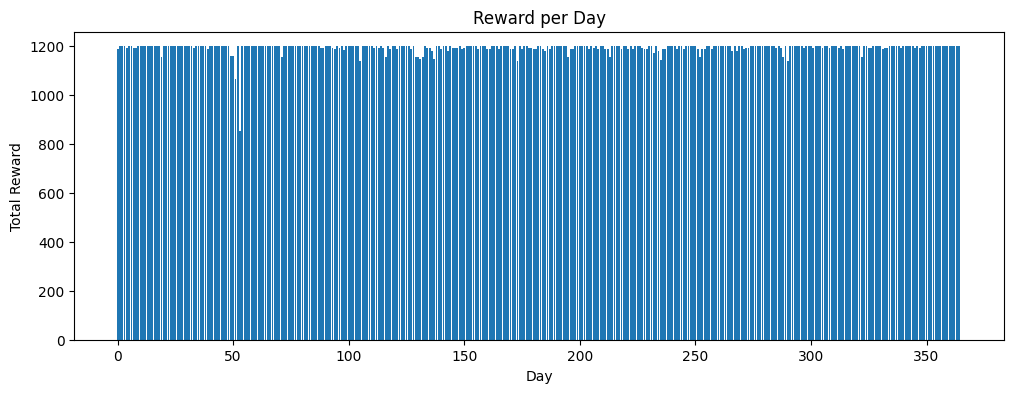

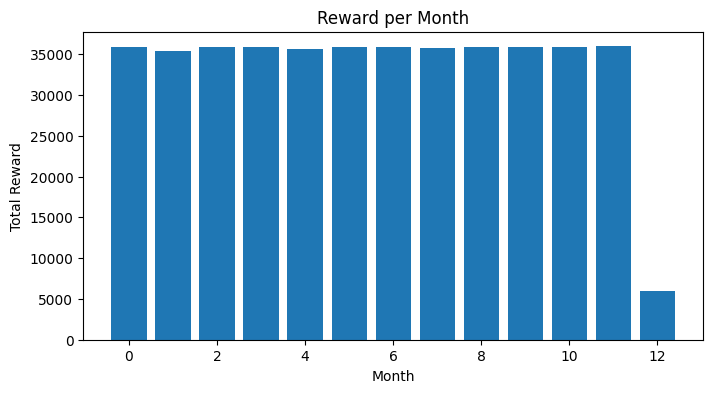

In [20]:
# Total reward per day
daily_reward_sums = {day: sum(log['reward']) for day, log in logs.items()}

# Aggregate by month (day // 30)
monthly_reward_sums = defaultdict(int)
for day, total in daily_reward_sums.items():
    month = day // 30
    monthly_reward_sums[month] += total

# Plot daily reward
plt.figure(figsize=(12, 4))
plt.bar(daily_reward_sums.keys(), daily_reward_sums.values())
plt.xlabel("Day")
plt.ylabel("Total Reward")
plt.title("Reward per Day")
plt.show()

# Plot monthly reward
plt.figure(figsize=(8, 4))
plt.bar(monthly_reward_sums.keys(), monthly_reward_sums.values())
plt.xlabel("Month")
plt.ylabel("Total Reward")
plt.title("Reward per Month")
plt.show()


In [21]:
# -------------------------------
# 2. Interactive Day Picker Plot
# -------------------------------
def plot_day(daily_logs, day):
    if day not in daily_logs:
        print(f"Day {day} not found.")
        return

    data = daily_logs[day]
    time_raw = [t for t in data['time'] if t % 15 == 0]
    idxs = [i for i, t in enumerate(data['time']) if t % 15 == 0]

    tto = [data['tto'][i] for i in idxs]
    rt = [data['room_temp'][i] for i in idxs]
    ot = [data['outside_temp'][i] for i in idxs]
    reward = [data['reward'][i] for i in idxs]
    cumulative_reward = [sum(reward[:i+1]) for i in range(len(reward))]

    fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    hours = [f"{t // 60:02d}:00" for t in range(0, 1440, 60)]
    xticks = [i for i, t in enumerate(time_raw) if t % 60 == 0]

    ax[0].plot(tto, label='Predicted Occupancy')
    ax[0].set_ylabel("Time to Occupancy.")
    ax[0].legend()

    ax[1].plot(rt, label='Indoor Temp')
    ax[1].plot(ot, label='Outdoor Temp', linestyle='--')
    ax[1].set_ylabel("Temperature (°C)")
    ax[1].legend()

    ax[2].plot(reward, label='Reward', color='green')
    ax[2].set_ylabel("Reward")
    ax[2].legend()

    ax[3].plot(cumulative_reward, label='Cumulative Reward', color='orange')
    ax[3].set_ylabel("Cumulative Reward")
    ax[3].set_xlabel("Time (hour)")
    ax[3].legend()

    plt.xticks(xticks, hours, rotation=45)
    plt.tight_layout()
    plt.show()


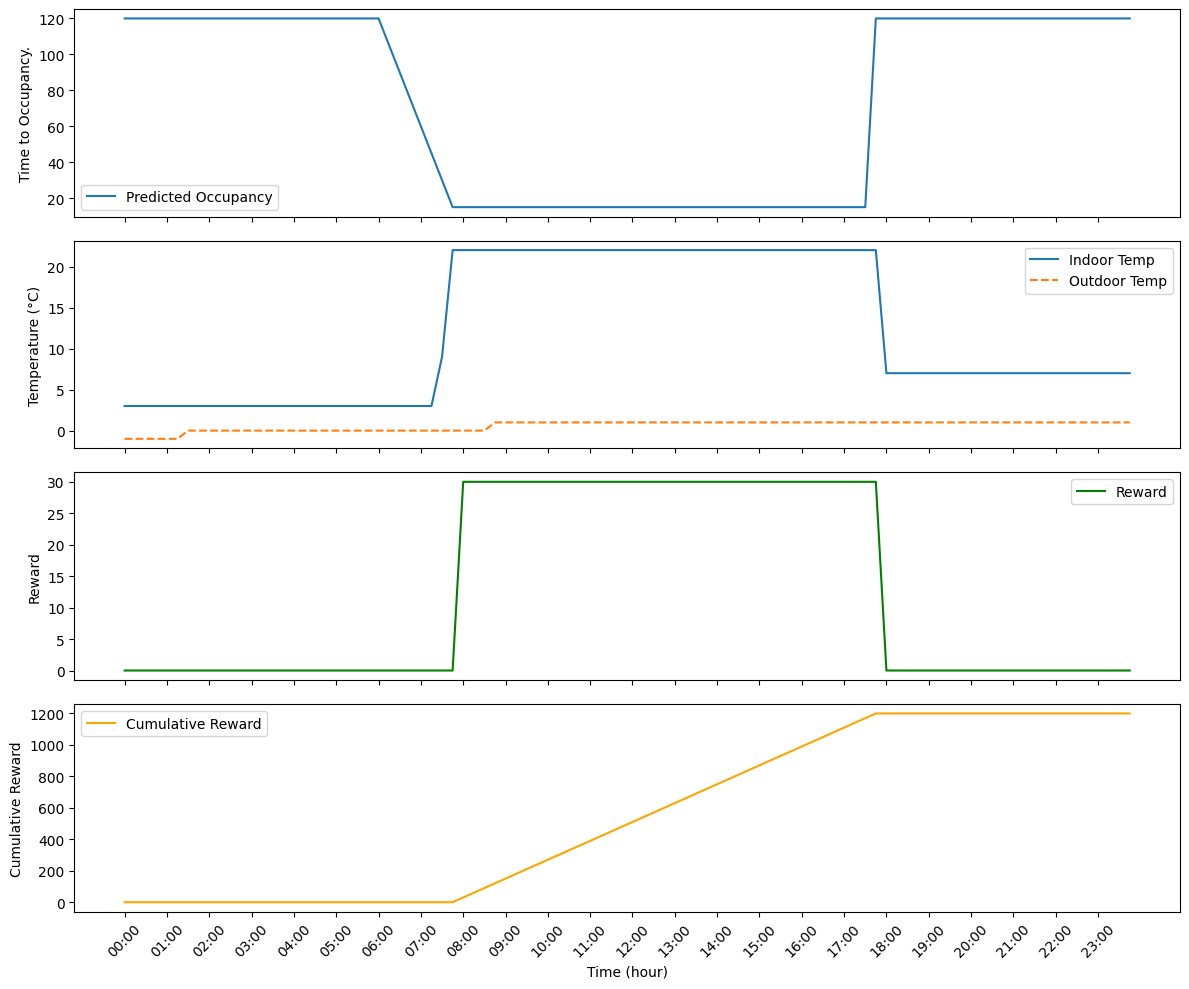

In [22]:
plot_day(logs, 55)

In [ ]:
# -------------------------------
# 1. Interactive Day Picker Widget
# -------------------------------

def interactive_day_plot(daily_logs):
    max_day = max(daily_logs.keys())

    day_selector = widgets.IntSlider(value=0, min=1, max=max_day, step=1, description='Day:')
    output = widgets.Output()

    def update_plot(change):
        with output:
            output.clear_output(wait=True)
            plot_day(daily_logs, day_selector.value)

    day_selector.observe(update_plot, names='value')

    display(day_selector, output)
    update_plot(None)  # initial plot

In [ ]:
interactive_day_plot(logs)


SIMULATE

In [ ]:
def simulate_day(day):
    q_table, predictor, daily_logs = load_model("model3.pkl")
    env = MyHvacEnv()
    env.bayesianOccupancyPredictor = predictor
    state, _ = env.reset()
    env.time = day * 1440 + 1
    initial_temp = get_outside_temp(env.time)
    state[0] = initial_temp   # rt
    state[2] = initial_temp   # ot
    state[1] = predictor.calculate_tto(env.time)  # tto
    env.state = np.array([state[0], state[1], state[2]], dtype=np.float32)

    pygame.init()
    WIDTH, HEIGHT = 800, 600
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Q-Table Day Simulation")
    font = pygame.font.SysFont(None, 28)
    clock = pygame.time.Clock()

    running = True
    paused = False
    step_index = 0

    def temp_color(temp):
        if temp < 20:
            return (0, 0, 255)
        elif temp > 25:
            return (255, 0, 0)
        else:
            return (0, 255, 0)

    def draw(state, action, reward):
        screen.fill((245, 245, 245))
        rt, tto, ot = state

        ot_size = np.interp(ot, [env.low[2], env.high[2]], [100, 400])
        ot_color = temp_color(ot)
        ot_rect = pygame.Rect(WIDTH//2 - ot_size//2, HEIGHT//2 - ot_size//2, ot_size, ot_size)
        pygame.draw.rect(screen, ot_color, ot_rect, width=4)

        rt_size = np.interp(rt, [env.low[0], env.high[0]], [50, ot_size-20])
        rt_color = temp_color(rt)
        rt_rect = pygame.Rect(WIDTH//2 - rt_size//2, HEIGHT//2 - rt_size//2, rt_size, rt_size)
        pygame.draw.rect(screen, rt_color, rt_rect)

        occ = is_working_hours(env.time)
        tri_color = (255, 165, 0) if occ else (128, 128, 128)
        cx, cy = WIDTH//2, HEIGHT//2
        size = rt_size / 3
        points = [
            (cx, cy - size / 2),
            (cx - size / 2, cy + size / 2),
            (cx + size / 2, cy + size / 2)
        ]
        pygame.draw.polygon(screen, tri_color, points)

        labels = [
            f"Day: {day}",
            f"Time: {env.time//60 % 24:02d}:{env.time % 60:02d}",
            f"Room Temp: {env.rt:.1f}°C",
            f"Outside Temp: {env.ot:.1f}°C",
            f"TTO: {env.tto:.1f} min",
            f"Action: {['Heat On','Cool On','Off'][action]}",
            f"Reward: {reward:.1f}",
            f"Occupied: {'Yes' if occ else 'No'}"
        ]
        for i, txt in enumerate(labels):
            surf = font.render(txt, True, (0, 0, 0))
            screen.blit(surf, (40, 40 + i * 30))

        pygame.display.flip()

    while running:
        clock.tick(15 if not paused else 3)

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    paused = not paused
                elif event.key == pygame.K_RIGHT:
                    day += 1
                    state, _ = env.reset()
                    env.time = day * 1440
                    new_temp = get_outside_temp(env.time)
                    state[0] = new_temp
                    state[2] = new_temp
                    state[1] = predictor.calculate_tto(env.time)
                    env.state = np.array([state[0], state[1], state[2]], dtype=np.float32)
                    step_index = 0
                elif event.key == pygame.K_LEFT:
                    day = max(0, day - 1)
                    state, _ = env.reset()
                    env.time = day * 1440
                    new_temp = get_outside_temp(env.time)
                    state[0] = new_temp
                    state[2] = new_temp
                    state[1] = predictor.calculate_tto(env.time)
                    env.state = np.array([state[0], state[1], state[2]], dtype=np.float32)
                    step_index = 0

        if not paused and running:
            tto_now = predictor.calculate_tto(env.time)
            current_rt = env.rt
            current_ot = env.ot
            state = np.array([current_rt, tto_now, current_ot], dtype=np.float32)
            state_key = (float(state[0]), float(state[1]), float(state[2]))

            if state_key not in q_table:
                print("Missing key in Q-table:", state_key)
                action = env.action_space.sample()
            else:
                action = int(np.argmax(q_table[state_key]))

            state, reward, terminated, truncated, _ = env.step(action)
            draw(state, action, reward)
            step_index += 1

            if step_index >= 1440 or terminated:
                paused = True

    pygame.quit()
    return


In [ ]:
simulate_day(55)